In [1]:
import json
import pandas as pd
import numpy as np
from preprocess import preprocess


In [2]:
def preprocessing_per_file(df,num=3):
    df=df[df['visible']==True].copy()
    preprocess_df=preprocess(df)

    df.drop(columns=['visible'])
    
    eps = 1e-15
    for i in range(1, num):
        df['x_lag_{}'.format(i)] = df['x'].shift(i)
        df['x_lag_inv_{}'.format(i)] = df['x'].shift(-i)
        df['y_lag_{}'.format(i)] = df['y'].shift(i)
        df['y_lag_inv_{}'.format(i)] = df['y'].shift(-i) 
        df['x_diff_{}'.format(i)] = abs(df['x_lag_{}'.format(i)] - df['x'])
        df['y_diff_{}'.format(i)] = df['y_lag_{}'.format(i)] - df['y']
        df['x_diff_inv_{}'.format(i)] = abs(df['x_lag_inv_{}'.format(i)] - df['x'])
        df['y_diff_inv_{}'.format(i)] = df['y_lag_inv_{}'.format(i)] - df['y']
        df['x_div_{}'.format(i)] = abs(df['x_diff_{}'.format(i)]/(df['x_diff_inv_{}'.format(i)] + eps))
        df['y_div_{}'.format(i)] = df['y_diff_{}'.format(i)]/(df['y_diff_inv_{}'.format(i)] + eps)
    
    
    for i in range(1, num):
        df = df[df['x_lag_{}'.format(i)].notna()]
        df = df[df['x_lag_inv_{}'.format(i)].notna()]
        
        
    colnames_x = ['x_diff_{}'.format(i) for i in range(1, num)] + \
                    ['x_diff_inv_{}'.format(i) for i in range(1, num)] + \
                    ['x_div_{}'.format(i) for i in range(1, num)]
    colnames_y = ['y_diff_{}'.format(i) for i in range(1, num)] + \
                    ['y_diff_inv_{}'.format(i) for i in range(1, num)] + \
                    ['y_div_{}'.format(i) for i in range(1, num)]
    colnames = colnames_x + colnames_y

    features = df[colnames]
    
    
        
    return preprocess_df.join(features)
        

In [3]:
import glob
import json
import pandas as pd
import numpy as np
from tqdm import tqdm

# 1. Define your folder path (Change 'data_folder' to your actual path)
folder_path = "data/*.json" 
file_list = glob.glob(folder_path)

frames_list = []
m = 15  # Window size (needed for the spacer)

print(f"Found {len(file_list)} files. Starting concatenation...")

# 2. Loop through every file in the folder
for filepath in tqdm(file_list):
    # B. Convert to DataFrame
    df_temp = pd.read_json(filepath)
    df_temp=df_temp.T
    #action=df_temp['action'].copy()
    df_temp=preprocessing_per_file(df_temp,num=5)
    #df_temp['action']=action
    
    # E. Add to list
    frames_list.append(df_temp)
    


# 3. Concatenate all files into one distinct DataFrame
full_df = pd.concat(frames_list)

print(f"Successfully created 'full_df' with shape: {full_df.shape}")

Found 313 files. Starting concatenation...


  0%|          | 0/313 [00:00<?, ?it/s]/home/ysidhom/Documents/M2DS/QSA_tennis/preprocess.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vx_after = df['x'].shift(-window_size).ffill() - df['x']
/home/ysidhom/Documents/M2DS/QSA_tennis/preprocess.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vy_after = df['y'].shift(-window_size).ffill() - df['y']
/home/ysidhom/Documents/M2DS/QSA_tennis/preprocess.py:334: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.inf

Successfully created 'full_df' with shape: (113673, 38)


In [4]:
full_df

,action,cosine_sim,speed_delta,acc_x,acc_y,acc_mag,dist_to_event,vx,vy,speed,...,y_diff_3,y_diff_4,y_diff_inv_1,y_diff_inv_2,y_diff_inv_3,y_diff_inv_4,y_div_1,y_div_2,y_div_3,y_div_4
324564,air,1.000000,27.073973,0.0,0.0,150.000000,12,10.0,-200.0,200.249844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
324565,air,0.999389,20.260403,0.0,0.0,150.000000,11,10.0,-205.0,205.243758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
324566,air,0.999764,8.037516,0.0,0.0,75.000000,10,10.0,-210.0,210.237960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
324567,air,0.999993,-3.653257,0.0,0.0,450.000000,9,15.0,-205.0,205.548048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
324568,air,0.987649,-9.071733,0.0,0.0,1000.624805,8,10.0,-180.0,180.277564,...,21,27,-7,-10,-12,-19,-0.857143,-1.3,-1.75,-1.421053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655760,air,0.903649,-2.509402,0.0,0.0,300.000000,16,-20.0,-95.0,97.082439,...,11,15,-3,-5,-8,-10,-1.333333,-1.4,-1.375,-1.5
655761,air,0.838279,-4.119038,0.0,0.0,540.832691,17,-25.0,-85.0,88.600226,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
655762,air,0.783668,-4.479658,0.0,0.0,1073.836580,18,-50.0,-75.0,90.138782,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
655763,air,0.700988,-6.951846,0.0,0.0,1052.675164,19,-95.0,-70.0,118.004237,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

X=full_df.drop(columns=['action'])
y=full_df['action']
# Step 1: Split the data into Training Set (60%) and a Temporary Set (40%)
# The test_size=0.4 means 40% goes into the temporary set.
X_train, X_temp, y_train, y_temp = train_test_split(
    X, 
    y, 
    test_size=0.4, 
    random_state=42 # Set a random state for reproducibility
)

# Step 2: Split the Temporary Set (40%) into Validation Set (20%) and Test Set (20%)
# Since X_temp is 40% of the original data, splitting it in half (test_size=0.5) 
# yields 20% for validation and 20% for testing (0.5 * 0.4 = 0.2).
X_validation, X_test, y_validation, y_test = train_test_split(
    X_temp, 
    y_temp, 
    test_size=0.5, 
    random_state=42
)

# --- 3. Verification ---
N_SAMPLES=X.shape[0]
print(f"Total Samples: {len(X)}")
print("-" * 30)
print(f"Training Set Size:    {len(X_train)} ({len(X_train)/N_SAMPLES:.0%})")
print(f"Validation Set Size:  {len(X_validation)} ({len(X_validation)/N_SAMPLES:.0%})")
print(f"Test Set Size:        {len(X_test)} ({len(X_test)/N_SAMPLES:.0%})")

Total Samples: 113673
------------------------------
Training Set Size:    68203 (60%)
Validation Set Size:  22735 (20%)
Test Set Size:        22735 (20%)


In [6]:
import catboost as ctb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


## --- 2. Model Initialization and Training ---

# Initialize the CatBoost Regressor model
# CatBoost is an ensemble technique (Gradient Boosting on Decision Trees) 
# Parameters are typically tuned, but we use defaults here for simplicity.
model = ctb.CatBoostClassifier(
            iterations=500,               
            learning_rate=0.05,
            loss_function='MultiClass',   # For predicting multiple action classes
            random_seed=42,
            verbose=0,                    # Suppress training output
            allow_writing_files=False,
        )

print("\nStarting CatBoost model training...")

# Train the model
model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),  # Data to evaluate performance on during training
    early_stopping_rounds=20,
)

print("Training finished.")

# You can save the model to a file, which is what your BounceDetector loads:
# model.save_model('my_catboost_model.cbm')


## --- 3. Evaluation and Prediction ---



Starting CatBoost model training...
Training finished.


--- Comprehensive Classification Evaluation ---
1. Overall Classification Accuracy: 0.9878

2. Detailed Classification Report (Per-Class Metrics):

              precision    recall  f1-score   support

         air       0.99      1.00      0.99     22153
      bounce       0.85      0.61      0.71       283
         hit       0.83      0.66      0.73       299

    accuracy                           0.99     22735
   macro avg       0.89      0.76      0.81     22735
weighted avg       0.99      0.99      0.99     22735


3. Confusion Matrix:
Rows are True labels, Columns are Predicted labels.
[[22087    28    38]
 [  108   174     1]
 [  100     3   196]]


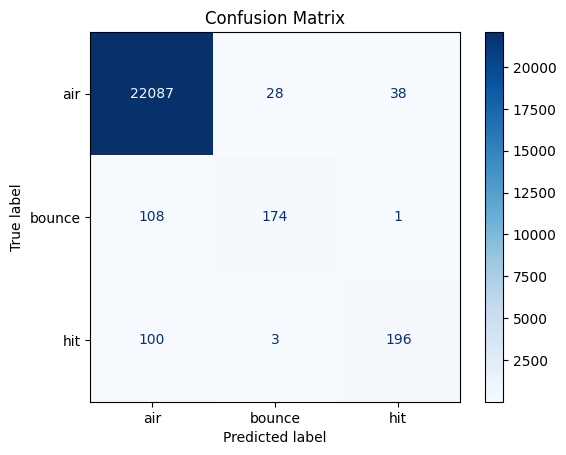

In [7]:

# Make predictions on the test set
y_pred = model.predict(X_test)

print("--- Comprehensive Classification Evaluation ---")
    
# 2. Overall Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"1. Overall Classification Accuracy: {accuracy:.4f}\n")

# 3. Detailed Classification Report (Precision, Recall, F1-Score per class)
print("2. Detailed Classification Report (Per-Class Metrics):\n")
report = classification_report(y_test, y_pred)
print(report)

# 4. Confusion Matrix (Visualizing misclassifications)
# The confusion matrix shows exactly where the model is making mistakes.
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

print("\n3. Confusion Matrix:")
print("Rows are True labels, Columns are Predicted labels.")
print(cm)

# Optional: Display the confusion matrix graphically (requires matplotlib)
try:
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
except Exception as e:
    print(f"\nCould not display Confusion Matrix plot. Error: {e}")

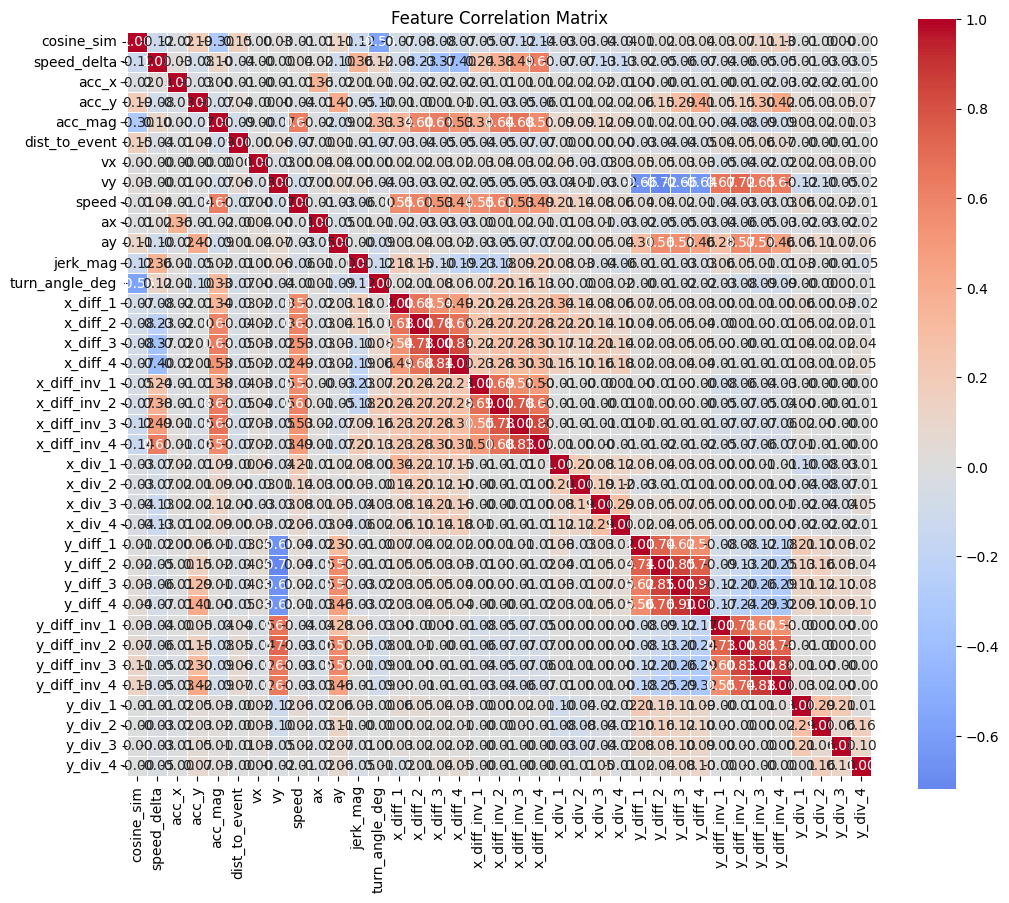

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Calculate the correlation matrix
# (assuming X is a pandas DataFrame)
corr_matrix = X.corr()

# 2. Plot the heatmap
plt.figure(figsize=(12, 10))  # Adjust size as needed
sns.heatmap(
    corr_matrix, 
    annot=True,       # Show the correlation numbers on the squares
    fmt=".2f",        # Format numbers to 2 decimal places
    cmap='coolwarm',  # Color map (red=high pos corr, blue=high neg corr)
    center=0,         # Center the colormap at 0
    square=True,      # Force squares to be square-shaped
    linewidths=.5     # Add lines between squares
)

plt.title("Feature Correlation Matrix")
plt.show()

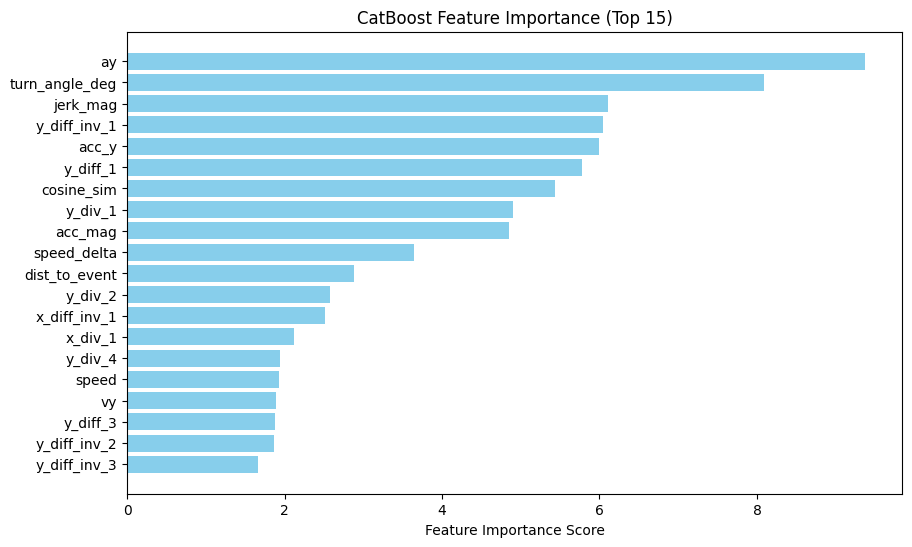

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Get the Best Model from your Grid Search
# If you ran the native grid_search, 'model' is already updated.
# If you used GridSearchCV, use: best_model = grid_search.best_estimator_

# For this example, we assume 'model' is your trained CatBoostClassifier

# 2. Extract Feature Importance
# 'type="FeatureImportance"' is the default (PredictionValuesChange)
# It measures how much the prediction changes on average when the feature value changes.
importance_values = model.get_feature_importance(type="FeatureImportance")

# 3. Map values to Feature Names
# We need the feature names from your training data (X_train)
feature_names = X_train.columns 

# Create a DataFrame for easy viewing
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_values
})

# Sort by importance (highest first)
importance_df = importance_df.sort_values(by='Importance', ascending=False)



# 5. Visualize with a Bar Plot
plt.figure(figsize=(10, 6))
# Invert y-axis to show the most important at the top
plt.barh(importance_df['Feature'][:20][::-1], importance_df['Importance'][:20][::-1], color='skyblue')
plt.xlabel('Feature Importance Score')
plt.title('CatBoost Feature Importance (Top 15)')
plt.show()

# try after Feature importance only keep 15

In [11]:
important_features=importance_df['Feature'][:20][::-1].to_list()

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

X=full_df[important_features]
y=full_df['action']
# Step 1: Split the data into Training Set (60%) and a Temporary Set (40%)
# The test_size=0.4 means 40% goes into the temporary set.
X_train, X_temp, y_train, y_temp = train_test_split(
    X, 
    y, 
    test_size=0.4, 
    random_state=42 # Set a random state for reproducibility
)

# Step 2: Split the Temporary Set (40%) into Validation Set (20%) and Test Set (20%)
# Since X_temp is 40% of the original data, splitting it in half (test_size=0.5) 
# yields 20% for validation and 20% for testing (0.5 * 0.4 = 0.2).
X_validation, X_test, y_validation, y_test = train_test_split(
    X_temp, 
    y_temp, 
    test_size=0.5, 
    random_state=42
)

# --- 3. Verification ---
N_SAMPLES=X.shape[0]
print(f"Total Samples: {len(X)}")
print("-" * 30)
print(f"Training Set Size:    {len(X_train)} ({len(X_train)/N_SAMPLES:.0%})")
print(f"Validation Set Size:  {len(X_validation)} ({len(X_validation)/N_SAMPLES:.0%})")
print(f"Test Set Size:        {len(X_test)} ({len(X_test)/N_SAMPLES:.0%})")

Total Samples: 113673
------------------------------
Training Set Size:    68203 (60%)
Validation Set Size:  22735 (20%)
Test Set Size:        22735 (20%)


In [13]:
import catboost as ctb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


## --- 2. Model Initialization and Training ---

# Initialize the CatBoost Regressor model
# CatBoost is an ensemble technique (Gradient Boosting on Decision Trees) 
# Parameters are typically tuned, but we use defaults here for simplicity.
model = ctb.CatBoostClassifier(
            iterations=500,               
            learning_rate=0.05,
            loss_function='MultiClass',   # For predicting multiple action classes
            random_seed=42,
            verbose=0,                    # Suppress training output
            allow_writing_files=False,
        )

print("\nStarting CatBoost model training...")

# Train the model
model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),  # Data to evaluate performance on during training
    early_stopping_rounds=20,
)

print("Training finished.")

# You can save the model to a file, which is what your BounceDetector loads:
# model.save_model('my_catboost_model.cbm')


## --- 3. Evaluation and Prediction ---



Starting CatBoost model training...
Training finished.


--- Comprehensive Classification Evaluation ---
1. Overall Classification Accuracy: 0.9860

2. Detailed Classification Report (Per-Class Metrics):

              precision    recall  f1-score   support

         air       0.99      1.00      0.99     22153
      bounce       0.77      0.57      0.65       283
         hit       0.81      0.63      0.71       299

    accuracy                           0.99     22735
   macro avg       0.86      0.73      0.79     22735
weighted avg       0.98      0.99      0.99     22735


3. Confusion Matrix:
Rows are True labels, Columns are Predicted labels.
[[22067    44    42]
 [  120   161     2]
 [  105     5   189]]


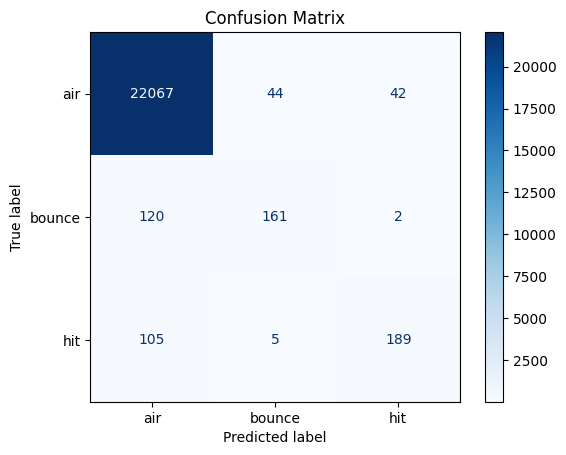

In [14]:

# Make predictions on the test set
y_pred = model.predict(X_test)

print("--- Comprehensive Classification Evaluation ---")
    
# 2. Overall Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"1. Overall Classification Accuracy: {accuracy:.4f}\n")

# 3. Detailed Classification Report (Precision, Recall, F1-Score per class)
print("2. Detailed Classification Report (Per-Class Metrics):\n")
report = classification_report(y_test, y_pred)
print(report)

# 4. Confusion Matrix (Visualizing misclassifications)
# The confusion matrix shows exactly where the model is making mistakes.
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

print("\n3. Confusion Matrix:")
print("Rows are True labels, Columns are Predicted labels.")
print(cm)

# Optional: Display the confusion matrix graphically (requires matplotlib)
try:
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
except Exception as e:
    print(f"\nCould not display Confusion Matrix plot. Error: {e}")

## Try lightGBM

In [20]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


X=full_df.drop(columns=['action']).astype(float)
y=full_df['action']

# ====================================================================
# 2. PREPROCESSING: ENCODE TARGET LABELS
# ====================================================================

# LightGBM requires integer targets (0, 1, 2)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Save the class names for later mapping (e.g. 0 -> 'air', 1 -> 'bounce')
class_names = le.classes_
print(f"Classes found: {class_names}")


Classes found: ['air' 'bounce' 'hit']


In [25]:
# ====================================================================
# 3. SPLIT DATA (Train / Validation / Test)
# ====================================================================

# Step 1: Split off the Test set (e.g., 20% of total data)
# This set is hidden and ONLY used for the final report.
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# Step 2: Split the remaining data (X_temp) into Train and Validation
# We want the Validation set to be roughly 20% of the ORIGINAL total.
# Since X_temp is 80% of the total, taking 0.25 of it gives us 20% (0.80 * 0.25 = 0.20).
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)

print(f"Train Size: {X_train.shape[0]} samples")
print(f"Valid Size: {X_val.shape[0]} samples")
print(f"Test Size:  {X_test.shape[0]} samples")


# ====================================================================
# 4. TRAIN LIGHTGBM MODEL (Updated with Validation)
# ====================================================================

# ... (Initialize your model as before) ...
model = lgb.LGBMClassifier(
    objective='multiclass',
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=500,
    class_weight='balanced',
    random_state=42,
    verbose=-1
)

model.fit(
    X_train, 
    y_train,
    # CRITICAL CHANGE: Use X_val for early stopping, NOT X_test
    eval_set=[(X_val, y_val)], 
    eval_metric='multi_logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=20)]
)

# Now your Test set (X_test) is perfectly clean for the final evaluation!



Train Size: 68203 samples
Valid Size: 22735 samples
Test Size:  22735 samples
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[485]	valid_0's multi_logloss: 0.0179516


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20



FINAL EVALUATION REPORT
Overall Accuracy: 0.9945

Classification Report:
              precision    recall  f1-score   support

         air       1.00      1.00      1.00     22178
      bounce       0.84      0.94      0.89       267
         hit       0.86      0.89      0.87       290

    accuracy                           0.99     22735
   macro avg       0.90      0.94      0.92     22735
weighted avg       0.99      0.99      0.99     22735

Confusion Matrix:
          air  bounce  hit
air     22103      36   39
bounce     13     250    4
hit        23      10  257

Plotting Feature Importance...


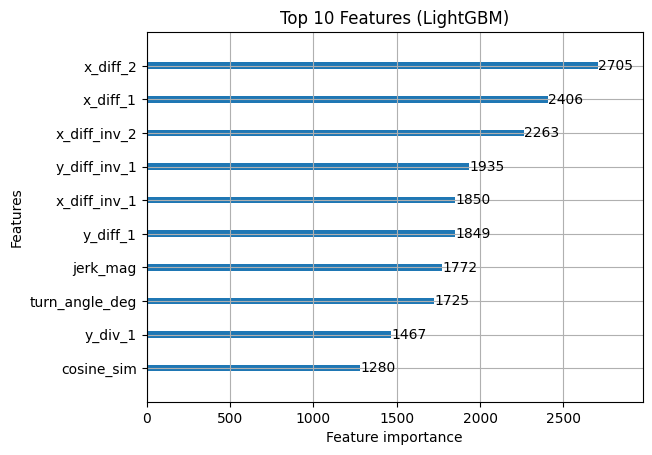

In [26]:

# ====================================================================
# 5. EVALUATE PREDICTIONS
# ====================================================================

# Predict class indices (0, 1, 2)
y_pred_indices = model.predict(X_test)

# Convert indices back to original strings ('air', 'bounce') for readability
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred_indices)

print("\n" + "="*40)
print("FINAL EVALUATION REPORT")
print("="*40)

# Accuracy
acc = accuracy_score(y_test_labels, y_pred_labels)
print(f"Overall Accuracy: {acc:.4f}\n")

# Detailed Report (Precision, Recall, F1)
print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=class_names)
print(pd.DataFrame(cm, index=class_names, columns=class_names))


# ====================================================================
# 6. FEATURE IMPORTANCE PLOT
# ====================================================================
print("\nPlotting Feature Importance...")
lgb.plot_importance(model, max_num_features=10, title='Top 10 Features (LightGBM)')
plt.show()

--- Comprehensive Classification Evaluation ---
1. Overall Classification Accuracy: 0.9872

2. Detailed Classification Report (Per-Class Metrics):

              precision    recall  f1-score   support

         air       0.99      1.00      0.99     21906


         bounce       0.91      0.52      0.66       307

         hit       0.82      0.67      0.74       272

         accuracy                           0.99     22485
         macro avg       0.91      0.73      0.80     22485
         weighted avg       0.99      0.99      0.99     22485


3. Confusion Matrix:
Rows are True labels, Columns are Predicted labels.
            [[21856    13    37]
            [  145   160     2]
            [   89     2   181]]


In [18]:
import catboost as ctb
import pandas as pd
import numpy as np


model = ctb.CatBoostClassifier(
    loss_function='MultiClass',
    eval_metric='TotalF1',      # Focus optimization on F1 Score
    early_stopping_rounds=20,   # Stop if F1 doesn't improve
    random_seed=42,
    verbose=0,
    allow_writing_files=False
)

# Define parameter grid
param_grid = {
    'iterations': [100, 300],
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6]
}

print("Starting Native CatBoost Grid Search...")

# Run native grid_search
# This bypasses sklearn completely, avoiding the AttributeError.
# It automatically handles splitting for validation.
grid_results = model.grid_search(
    param_grid, 
    X=X_train, 
    y=y_train,
    cv=3,       # 3-fold cross-validation
    partition_random_seed=42,
    search_by_train_test_split=True, # Validates on a hold-out portion
    verbose=False,
    plot=False
)

# 3. RESULTS
# -------------------------------------------------------------------
print("\n--- Best Parameters Found ---")
print(grid_results['params'])

print("\n--- Best F1 Score (Approximate) ---")
# The 'cv_results' dictionary contains the history of metrics
best_f1 = max(grid_results['cv_results']['test-TotalF1-mean'])
print(f"{best_f1:.4f}")

# The 'model' object is automatically refitted with the best params
print("\nModel is ready for prediction!")

Starting Native CatBoost Grid Search...
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9640025599
bestIteration = 0

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9640025599
bestIteration = 0

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9640025599
bestIteration = 0

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9640025599
bestIteration = 0

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9631234934
bestIteration = 0


bestTest = 0.9775373221
bestIteration = 95

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9631234934
bestIteration = 0


bestTest = 0.9856019841
bestIteration = 299

Training on fold [0/3]

bestTest = 0.9853336391
bestIteration = 298

Training on fold [1/3]

bestTest = 0.9824403237
bestIteration = 299

Training on fold [2/3]

bestTest = 0.9837309898
bestIteration = 297


--- Best Parameters Found ---
{'depth': 6, 'learning_rate': 0.1, 'iterati

In [21]:
type(grid_results)

dict

--- Comprehensive Classification Evaluation ---
1. Overall Classification Accuracy: 0.9879

2. Detailed Classification Report (Per-Class Metrics):

              precision    recall  f1-score   support

         air       0.99      1.00      0.99     21906
      bounce       0.92      0.54      0.68       307
         hit       0.83      0.70      0.76       272

    accuracy                           0.99     22485
   macro avg       0.91      0.75      0.81     22485
weighted avg       0.99      0.99      0.99     22485


3. Confusion Matrix:
Rows are True labels, Columns are Predicted labels.
[[21854    14    38]
 [  138   167     2]
 [   80     1   191]]


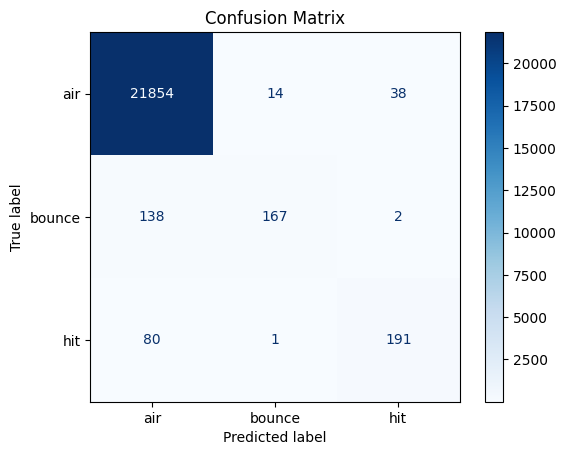

In [23]:
y_pred=model.predict(X_test)

print("--- Comprehensive Classification Evaluation ---")
    
# 2. Overall Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"1. Overall Classification Accuracy: {accuracy:.4f}\n")

# 3. Detailed Classification Report (Precision, Recall, F1-Score per class)
print("2. Detailed Classification Report (Per-Class Metrics):\n")
report = classification_report(y_test, y_pred)
print(report)

# 4. Confusion Matrix (Visualizing misclassifications)
# The confusion matrix shows exactly where the model is making mistakes.
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

print("\n3. Confusion Matrix:")
print("Rows are True labels, Columns are Predicted labels.")
print(cm)

# Optional: Display the confusion matrix graphically (requires matplotlib)
try:
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
except Exception as e:
    print(f"\nCould not display Confusion Matrix plot. Error: {e}")


## add my values 


In [35]:
from preprocess import preprocess

df=pd.read_json("data/ball_data_79.json")
df=df.T
#let's not consider the frames where the ball is not detected (not visible)
print("Initial number of frames:",df.shape)
df=df[df['visible']==1]
print("Number of frames with ball visible:",df.shape)

Initial number of frames: (205, 4)
Number of frames with ball visible: (112, 4)


In [36]:
df_theirs=preprocessing_per_file(df)

In [ ]:
df_mine=preprocess(df)
df_mine.columns
df_mine=preprocess(df)
to_drop=['x', 'y', 'visible','x_smooth', 'y_smooth']
df_mine=df_mine.drop(columns=to_drop)

/home/ysidhom/Documents/M2DS/QSA_tennis/preprocess.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vx_after = df['x'].shift(-window_size).ffill() - df['x']
/home/ysidhom/Documents/M2DS/QSA_tennis/preprocess.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vy_after = df['y'].shift(-window_size).ffill() - df['y']
/home/ysidhom/Documents/M2DS/QSA_tennis/preprocess.py:336: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-

Index(['x', 'y', 'visible', 'action', 'x_smooth', 'y_smooth', 'cosine_sim',
       'speed_delta', 'y_distortion', 'x_distortion', 'acc_x', 'acc_y',
       'acc_mag', 'y_diff', 'x_diff', 'dist_to_event', 'vx', 'vy', 'speed',
       'ax', 'ay', 'jerk_mag', 'turn_angle_deg'],
      dtype='object')

/home/ysidhom/Documents/M2DS/QSA_tennis/preprocess.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vx_after = df['x'].shift(-window_size).ffill() - df['x']
/home/ysidhom/Documents/M2DS/QSA_tennis/preprocess.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vy_after = df['y'].shift(-window_size).ffill() - df['y']
/home/ysidhom/Documents/M2DS/QSA_tennis/preprocess.py:336: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-

In [46]:
# df1 is your first dataframe
# df2 is your second dataframe

df_merged = df_mine.join(df_theirs)

In [47]:
df_merged

,action,cosine_sim,speed_delta,y_distortion,x_distortion,acc_x,acc_y,acc_mag,y_diff,x_diff,...,x_diff_inv_1,x_diff_inv_2,x_div_1,x_div_2,y_diff_1,y_diff_2,y_diff_inv_1,y_diff_inv_2,y_div_1,y_div_2
235716,air,1.000000,16.401220,1.0,1.0,0.0,0.0,424.264069,9.523810,7.323810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235717,air,0.986903,9.292212,1.0,1.0,0.0,0.0,540.832691,12.471429,9.185714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235718,air,0.997758,3.434757,1.0,1.0,0.0,0.0,546.008242,13.559524,9.230952,...,2,6,1.5,1.166667,2,6,-2,-4,-1.0,-1.5
235719,air,0.979987,0.899481,1.0,1.0,0.0,0.0,309.232922,14.758730,9.047619,...,4,7,0.5,0.714286,2,4,-2,-3,-1.0,-1.333333
235720,air,0.914180,-2.201196,1.0,1.0,0.0,0.0,212.132034,16.302381,8.545238,...,3,4,1.333333,1.5,2,4,-1,-3,-2.0,-1.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235856,bounce,-0.802370,-45.605301,-1.0,-1.0,0.0,0.0,17358.784869,4.077463,-130.071429,...,10.014851,11.985149,0.997034,1.25031,-73.5,-115.5,44.5,8.5,-1.651685,-13.588235
235864,air,-0.885440,-13.380219,-1.0,-1.0,0.0,0.0,29740.900873,9.695521,-90.371429,...,22,25,0.455221,0.8,-44.5,-118,-36,-41,1.236111,2.878049
235876,air,-0.819496,-8.657394,-1.0,1.0,0.0,0.0,35291.232420,15.713720,-49.161905,...,3,76,7.333333,0.157699,36,-8.5,-5,-98,-7.2,0.086735
235877,air,-0.275758,66.741592,1.0,1.0,0.0,0.0,23416.670176,18.050896,-14.883333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

X=full_df.drop(columns=['action'])
y=full_df['action']
# Step 1: Split the data into Training Set (60%) and a Temporary Set (40%)
# The test_size=0.4 means 40% goes into the temporary set.
X_train, X_temp, y_train, y_temp = train_test_split(
    X, 
    y, 
    test_size=0.4, 
    random_state=42 # Set a random state for reproducibility
)

# Step 2: Split the Temporary Set (40%) into Validation Set (20%) and Test Set (20%)
# Since X_temp is 40% of the original data, splitting it in half (test_size=0.5) 
# yields 20% for validation and 20% for testing (0.5 * 0.4 = 0.2).
X_validation, X_test, y_validation, y_test = train_test_split(
    X_temp, 
    y_temp, 
    test_size=0.5, 
    random_state=42
)

# --- 3. Verification ---
N_SAMPLES=X.shape[0]
print(f"Total Samples: {len(X)}")
print("-" * 30)
print(f"Training Set Size:    {len(X_train)} ({len(X_train)/N_SAMPLES:.0%})")
print(f"Validation Set Size:  {len(X_validation)} ({len(X_validation)/N_SAMPLES:.0%})")
print(f"Test Set Size:        {len(X_test)} ({len(X_test)/N_SAMPLES:.0%})")

Total Samples: 112421
------------------------------
Training Set Size:    67452 (60%)
Validation Set Size:  22484 (20%)
Test Set Size:        22485 (20%)


In [ ]:
import catboost as ctb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


## --- 2. Model Initialization and Training ---

# Initialize the CatBoost Regressor model
# CatBoost is an ensemble technique (Gradient Boosting on Decision Trees) 
# Parameters are typically tuned, but we use defaults here for simplicity.
model = ctb.CatBoostClassifier(
            iterations=500,               
            learning_rate=0.05,
            loss_function='MultiClass',   # For predicting multiple action classes
            random_seed=42,
            verbose=0,                    # Suppress training output
            allow_writing_files=False,
        )

print("\nStarting CatBoost model training...")

# Train the model
model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),  # Data to evaluate performance on during training
    early_stopping_rounds=20,
)

print("Training finished.")

# You can save the model to a file, which is what your BounceDetector loads:
# model.save_model('my_catboost_model.cbm')


## --- 3. Evaluation and Prediction ---



Starting CatBoost model training...
Training finished.


--- Comprehensive Classification Evaluation ---
1. Overall Classification Accuracy: 0.9872

2. Detailed Classification Report (Per-Class Metrics):

              precision    recall  f1-score   support

         air       0.99      1.00      0.99     21906
      bounce       0.91      0.52      0.66       307
         hit       0.82      0.67      0.74       272

    accuracy                           0.99     22485
   macro avg       0.91      0.73      0.80     22485
weighted avg       0.99      0.99      0.99     22485


3. Confusion Matrix:
Rows are True labels, Columns are Predicted labels.
[[21856    13    37]
 [  145   160     2]
 [   89     2   181]]


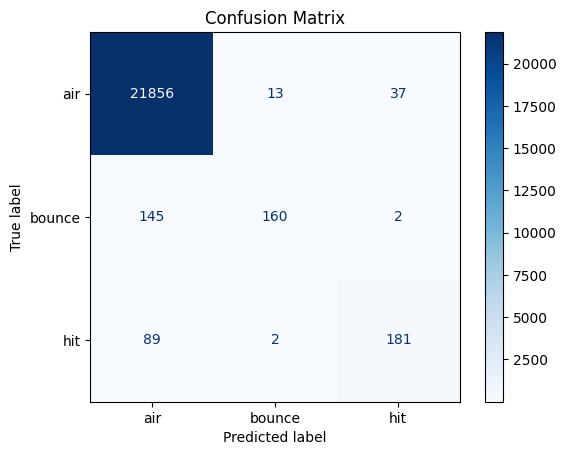

In [ ]:

# Make predictions on the test set
y_pred = model.predict(X_test)

print("--- Comprehensive Classification Evaluation ---")
    
# 2. Overall Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"1. Overall Classification Accuracy: {accuracy:.4f}\n")

# 3. Detailed Classification Report (Precision, Recall, F1-Score per class)
print("2. Detailed Classification Report (Per-Class Metrics):\n")
report = classification_report(y_test, y_pred)
print(report)

# 4. Confusion Matrix (Visualizing misclassifications)
# The confusion matrix shows exactly where the model is making mistakes.
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

print("\n3. Confusion Matrix:")
print("Rows are True labels, Columns are Predicted labels.")
print(cm)

# Optional: Display the confusion matrix graphically (requires matplotlib)
try:
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
except Exception as e:
    print(f"\nCould not display Confusion Matrix plot. Error: {e}")